In [1]:
import kwant
import tinyarray
import numpy as np
import scipy as spi
import scipy.constants as const
import scipy.signal as signal

import matplotlib.pyplot as plt 
import matplotlib.colors as colors
print(const.e)
plt.rcParams.update({'font.size': 20})

mu_B = const.physical_constants['Bohr magneton'][0]
B = 14.7*mu_B*2./2./const.e*1000.
B

1.602176634e-19


0.8508921254871452

In [2]:
## realistic parameters InAs with Al shell
# Energy unit: meV, length unit: A
#g = 14.7 #https://doi.org/10.1016/0375-9601(67)90541-5

def make_system_mixed(L_A=3700., W=1400., a=6.0583*10., m=0.023, alpha=350., mu=0., delta=0.182, B=0., phi=0., eta=None):
    
    #a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
    L = int(np.round(L_A/a))
    t = (const.hbar**2.)/(2.*m*const.m_e*(a*1e-10)**2.)/const.e*1000.
    E_plus = (6.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    E_minus = (-2.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    if eta is None:
        eta = np.sqrt(2)*alpha/W
    else:
        eta = eta
    nu = alpha/(2.*a)
    #B = g*mu_B*B_Tesla/2./const.e*1000.
    print('Parameters: L, t, E_plus, E_minus, eta, nu, B')
    print([L, t, E_plus, E_minus, eta, nu, B])
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    t_x = np.kron(np.kron(np.array([[0, 1], [1, 0]]), np.eye(2)), np.eye(2)) # e-h subspace
    t_y = np.kron(np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2)), np.eye(2))
    t_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))
    sigma_x = np.kron(np.kron(np.eye(2), np.array([[0, 1], [1, 0]])), np.eye(2)) # subband subspace
    sigma_y = np.kron(np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]])), np.eye(2))
    sigma_z = np.kron(np.kron(np.eye(2), np.array([[1, 0], [0, -1]])), np.eye(2))
    s_x = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, 1], [1, 0]])) # spin subspace
    s_y = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, -1j], [1j, 0]]))
    s_z = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[1, 0], [0, -1]]))
    
    #### Define the scattering region. ####
    ham = (2.*t+E_plus-mu)*t_z + E_minus*sigma_z@t_z + eta*s_x@sigma_y@t_z + B*s_x
    hop = -t*t_z + 1j*nu*s_y@t_z
    ham_scl = delta*(np.cos(-phi/2.)*t_x - np.sin(-phi/2.)*t_y)
    ham_scr = delta*(np.cos(phi/2.)*t_x - np.sin(phi/2.)*t_y)
    
    syst[(lat(x) for x in range(0, L))] = ham
    syst[((lat(x), lat(x+1)) for x in range(0, L-1))] = hop
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = ham+ham_scl
    lead0[lat.neighbors()] = hop.T.conj()
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  ham+ham_scr
    lead1[lat.neighbors()] = hop.T.conj()

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

In [14]:
ABSOL_MU

0.36197780743103836

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 44.767152195754, 1.0141922225789335, -0.3380640741929778, 0.5, 2.8768699654775607, 0.0]
0.41063003169885676
0.7726078391298952


"print('Spectral gap:')\nprint(np.min(en[:,4]))\nprint(np.min(en[:,5]))\nprint('Fermi momentum')\nk_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,4])])/6.0583e-10\nprint(k_F)\nprint('Fermi wavelength:')\nprint(2.*np.pi/k_F)\n# Fermi wavelength comparable to junction length\nlocal_minima = signal.argrelextrema(en[:,4], np.less)\nprint(local_minima)\nprint(en[local_minima, 4])\nprint(np.abs(np.linspace(-np.pi,np.pi,100001)[local_minima]))"

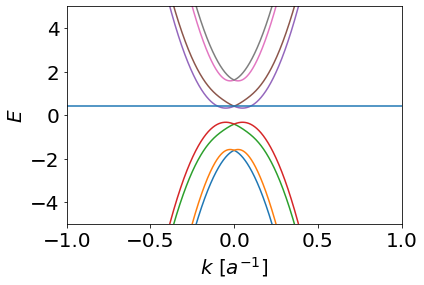

In [15]:
#mu above crossing 0.36197780743103836
syst = make_system_mixed(L_A=3700., W=1400., a=6.083*10, m=0.023, alpha=350., mu=0., delta=0., B=0., phi=0., eta=0.5)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,10001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
plt.xlabel(r'$k\ [a^{-1}]$')
plt.ylabel(r'$E$')
plt.xlim(-1, 1)
plt.ylim(-5, 5)
print(bands(0.)[4])
plt.axhline(bands(0.)[4])
print(bands(0.)[4]+ABSOL_MU)

#ABSOL_MU = 0.887-bands(0.)[4]


'''print('Spectral gap:')
print(np.min(en[:,4]))
print(np.min(en[:,5]))
print('Fermi momentum')
k_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,4])])/6.0583e-10
print(k_F)
print('Fermi wavelength:')
print(2.*np.pi/k_F)
# Fermi wavelength comparable to junction length
local_minima = signal.argrelextrema(en[:,4], np.less)
print(local_minima)
print(en[local_minima, 4])
print(np.abs(np.linspace(-np.pi,np.pi,100001)[local_minima]))'''